In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.misc as sm
data_dir = '/home/lioruzan/pixel-cnn/data/letters_data'
import pickle as pkl

with open(os.path.join(data_dir,'letters_test.pkl'),'rb') as f:
    test_letters= pkl.load(f)

In [7]:
t=test_letters['labels'][:36]

In [1]:
''' PARSE DATA '''
import pandas as pd
import os

labels_csv = os.path.join('letters_data', 'labels.csv')
df = pd.read_csv(labels_csv, encoding='ISO-8859-8', header=None)
df = df.applymap(str.strip)

# clean data
doubles = df.applymap(lambda x: True if len(x)>1 and x.find('!') == -1 else False)[1]
X       = df.applymap(lambda x: True if x == 'X' else False)[1]

df = df[~doubles & ~X].reset_index(drop=True)

# label fix ש -> ה
df.iloc[3659][1]='ה!'

root = 'letters_data'
file_list = []
label_list = []
for _,y in df.iterrows():
    file_list.append(os.path.join(root,y[0][1:].replace('\\','/')))
    label_list.append(y[1])

l = sorted(list(set(label_list)))
label_to_idx = {}
for i,j in enumerate(l):
    label_to_idx[j] = i
label_list = [label_to_idx[s] for s in label_list]

In [28]:
''' MAKE IMAGES '''
import scipy.misc as sm
import numpy as np

imgs = [sm.imread(file,mode='RGB') for file in file_list]

# resized_imgs = [sm.imresize(im,(32,32)) for im in imgs]

# resized_imgs = [im[np.newaxis,:,:,:] for im in resized_imgs]
# images = np.vstack(resized_imgs)
# labels = np.array(label_list)

[ 192.  167.    3.] [ 47.07156859  29.70098797   0.        ]


In [29]:
''' IMAGE STATS '''
shapes=[o.shape for o in imgs]
print(np.median(shapes, axis=0), np.mean(shapes, axis=0), np.std(shapes, axis=0))
print(np.max(shapes,axis=0),np.min(shapes,axis=0))
print(np.argmax(shapes, axis=0), np.argmin(shapes,axis=0))

[ 192.  167.    3.] [ 208.19724556  168.49743231    3.        ] [ 47.07156859  29.70098797   0.        ]


In [83]:
''' PARSE AND RESIZE IMAGES'''
def parse_resize(imgs, s=32):
    img_rsz = np.zeros((len(imgs),s,s,3), dtype=np.uint8)
    c=s//2
    for j,im in enumerate(imgs):
        h,w = im.shape[0],im.shape[1]
        if h>s:
            ar = s/h
            im = sm.imresize(im, ar, interp='bicubic')
            h, w = im.shape[0], im.shape[1]
        if w>s:
            ar = s/w
            im = sm.imresize(im,ar,interp='bicubic')
            h, w = im.shape[0], im.shape[1]
        img_rsz[j,(c-h//2):(c+h//2+h%2),(c-w//2):(c+w//2+w%2),:]=im
    return img_rsz

In [84]:
o=parse_resize(imgs)

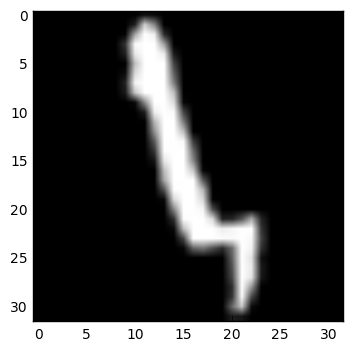

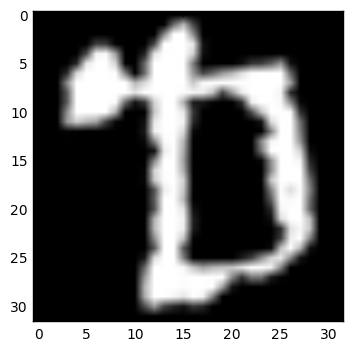

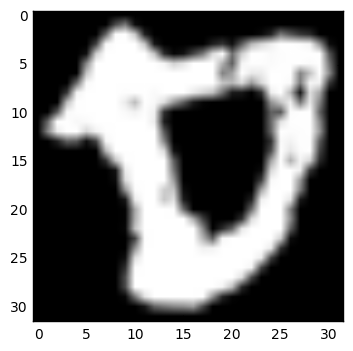

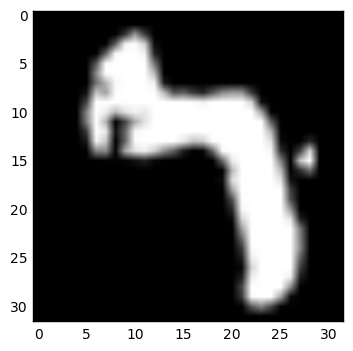

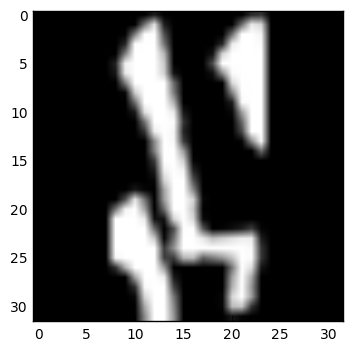

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline
for j in np.random.permutation(4284)[:5]:
    plt.imshow(o[j])
    plt.show()

In [27]:
sm.imshow(imgs[952])

In [17]:
test_files

['letters_data/Segmentation-based_Dataset/Cand3/candidates_38/cand1.jpg',
 'letters_data/Segmentation-based_Dataset/Cand3/candidates_38/cand10.jpg',
 'letters_data/Segmentation-based_Dataset/Cand3/candidates_38/cand100.jpg',
 'letters_data/Segmentation-based_Dataset/Cand3/candidates_38/cand101.jpg',
 'letters_data/Segmentation-based_Dataset/Cand3/candidates_38/cand102.jpg',
 'letters_data/Segmentation-based_Dataset/Cand3/candidates_38/cand11.jpg',
 'letters_data/Segmentation-based_Dataset/Cand3/candidates_38/cand12.jpg',
 'letters_data/Segmentation-based_Dataset/Cand3/candidates_38/cand13.jpg',
 'letters_data/Segmentation-based_Dataset/Cand3/candidates_38/cand14.jpg',
 'letters_data/Segmentation-based_Dataset/Cand3/candidates_38/cand15.jpg',
 'letters_data/Segmentation-based_Dataset/Cand3/candidates_38/cand16.jpg',
 'letters_data/Segmentation-based_Dataset/Cand3/candidates_38/cand17.jpg',
 'letters_data/Segmentation-based_Dataset/Cand3/candidates_38/cand18.jpg',
 'letters_data/Segmenta

In [72]:
def reverse(l):
    n=len(l)
    return [l[j] for j in range(n-1,-1,-1)]
s = [l[i] for i in t]
for i in range(6):
    print('{:>2}\t{:>2}\t{:>2}\t{:>2}\t{:>2}\t{:>2}\t'.format(*reverse(s[6*i:6*(i+1)])))
    print()

ה!	 ה	 פ	 ס	 ד	 ר	

 מ	 ת	 ה	 ט	 ם	 צ	

 ר	 א	 ר	 ם	 ה	 ה	

 ה	 נ	 ל	 ג	 ך	 ל	

 ל	 ם	 מ	 י	 ו	 ד	

 ק	 ש	 א	 ה	 ה	 ה	



י


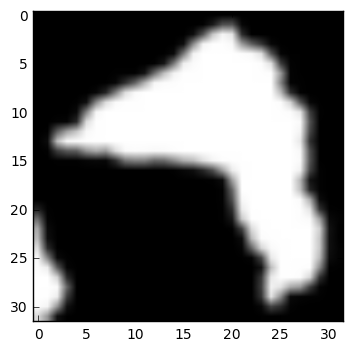

In [45]:
r = np.random.randint(36)
print(l[t[r]])
plt.imshow(test_letters['data'][r])
plt.show()